<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/05-modern-training-techniques/01_training_model_with_optimizers_and_schedulers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Training model with optimizers and schedulers

There is an issue with the learning rate $\eta$. We choose one learning rate for every batch of every epoch of training.

So, the first type of improvement is to alter the learning rate $\eta$ as a
function of how far along we are in the optimization process $(t)$.

Right now, the important thing is
to understand that we have created an abstraction for altering the learning rate, and this
abstraction is called a learning rate schedule.

The learning rate $\eta$ simply controls how quickly we follow that information. But the gradient $g^t$ is only as good as the data we use to train the model. If our data is noisy (and it almost
always is), our gradients will also be noisy.

The other two are real problems. Say, for example, that we sometimes get a
gradient $g^t$ that is just too large. 

This can happen when we add hundreds of layers to our
network and is a common problem called an exploding gradient.

The opposite situation occurs too; the gradient could be too small $|| g^t ||_2 \to \infty$, causing us to make no progress toward training
(even with a large $\eta$). 

This is called a vanishing gradient and can occur in almost any
architecture but is particularly common when we use the $tanh(.)$ and $\sigma(.)$ activation functions.

PyTorch provides two interfaces for us to implement the learning rate schedule $L(., .)$ and the gradient $G(.)$ functions.

<img src='images/1.png?raw=1' width='600'/>

Let's implement optimizers and schedulers.

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

from sklearn.datasets import make_moons

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from idlmam import train_simple_network, Flatten, weight_reset, set_seed, run_epoch

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from IPython.display import display_pdf
from IPython.display import Latex

torch.backends.cudnn.deterministic=True
set_seed(45)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

In [ ]:
epochs = 50
B = 256

train_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("./data", train=False, transform=transforms.ToTensor(), download=True)

training_loader = DataLoader(train_data, batch_size=B, shuffle=True)
testing_loader = DataLoader(test_data, batch_size=B)

##Updating training function

In [ ]:
def train_network(model, loss_func, train_loader, test_loader=None, score_funcs=None, epochs=50, device="cpu", checkpoint_file=None):

  tracking = ["epoch", "total time", "train loss"]

  if test_loader is not None:
    tracking.append("test loss")
  
  for eval_score in score_funcs:
    tracking.append("train " + eval_score)
    if test_loader is not None:
      tracking.append("test " + eval_score)

  # How long have we spent in the training loop?
  total_train_time = 0
  results = {}
  # Initialize every item with an empty list
  for item in tracking:
    results[item] = []

  # SGD is Stochastic Gradient Decent
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

  # Place the model on the correct compute resource (CPU or GPU)
  model.to(device)

  # iterating through all the data (batches) multiple times (epochs)
  for epoch in tqdm(range(epochs), desc="Epoch"):
    # Put the model in training mode
    model = model.train()

    # train the model
    total_train_time += train_model(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
    
    results["total time"].append(total_train_time)
    results["epoch"].append(epoch)

    if test_loader is not None:
      model = model.eval()
      with torch.no_grad():
        train_model(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

  # lets us save the model, the optimizer state, and other information, all in one object
  if checkpoint_file is not None:
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "results": results
    }, checkpoint_file)

  # Finally, convert the results into a pandas DataFrame
  return pd.DataFrame.from_dict(results)

##Training model

We have everything we need to train our model.

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)

loss_func = nn.CrossEntropyLoss()

results_pd = train_network(model, 
                          loss_func, 
                          training_loader,
                          epochs=5, test_loader=testing_loader,
                          checkpoint_file="model.pt",
                          score_funcs={"Acc": accuracy_score, "F1": f1_score})

In [ ]:
results_pd.head()

,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,5.104410,0.430262,0.394384,0.811625,0.830,0.810369,0.830000
1,1,14.918572,0.377710,0.392896,0.833375,0.835,0.832643,0.835821
2,2,24.109392,0.376355,0.394390,0.834375,0.835,0.834064,0.835821
3,3,29.001207,0.375273,0.393163,0.834875,0.835,0.834772,0.835821
4,4,33.748391,0.374356,0.391574,0.836750,0.835,0.836750,0.835821


In [ ]:
results_pd.tail()

,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,5.104410,0.430262,0.394384,0.811625,0.830,0.810369,0.830000
1,1,14.918572,0.377710,0.392896,0.833375,0.835,0.832643,0.835821
2,2,24.109392,0.376355,0.394390,0.834375,0.835,0.834064,0.835821
3,3,29.001207,0.375273,0.393163,0.834875,0.835,0.834772,0.835821
4,4,33.748391,0.374356,0.391574,0.836750,0.835,0.836750,0.835821


let’s see that we can load our checkpoint model.

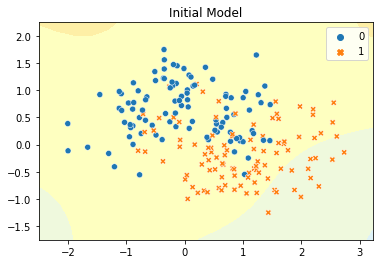

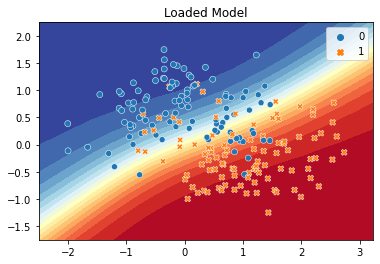

In [ ]:
model_new = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)

visualize2DSoftmax(x_test, y_test, model_new)
plt.title("Initial Model")
plt.show()

# load the model
checkpoint_dict = torch.load("model.pt", map_location="cpu")
model_new.load_state_dict(checkpoint_dict["model_state_dict"])

visualize2DSoftmax(x_test, y_test, model_new)
plt.title("Loaded Model")
plt.show()

You can easily see that the initial model does not give very good predictions because its
weights are random values and untrained.

Let's quickly plot the training and validation
accuracy.

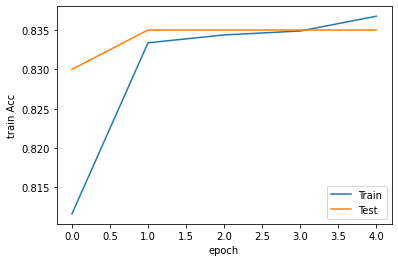

In [ ]:
sns.lineplot(x="epoch", y="train Acc", data=results_pd, label="Train")
sns.lineplot(x="epoch", y="test Acc", data=results_pd, label="Test")

It’s now easy to see that by using more data, it took about two epochs for our model to
top out on the noisier training data.

let’s look
at the F1 score.

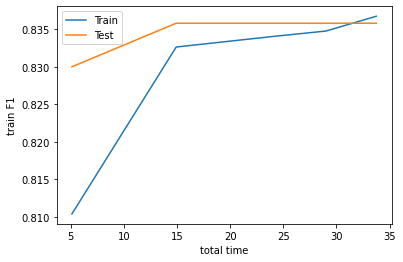

In [ ]:
sns.lineplot(x="total time", y="train F1", data=results_pd, label="Train")
sns.lineplot(x="total time", y="test F1", data=results_pd, label="Test")

##Training in batches

If we push all $N$ data points through the model and compute the loss over the
entire dataset, $\sum_{i=1}^N l(f(x_i), y_i)$ we get the true gradient.

This can also make our
training more computationally efficient by processing all of the data at once instead of
one datum at a time.

So instead of passing in a vector with a shape of $(d)$ as the input
to a model $f(.)$, we pass in a matrix of shape $(N, d)$.

PyTorch modules are designed for
this situation by default; we just need a way to tell PyTorch to group our data into a
larger batch. It turns out the DataLoader has this functionality built in with the optional
`batch_size` argument.

In [ ]:
training_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [ ]:
model_gd = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)

results_true_gd = train_network(model_gd, 
                                loss_func, 
                                training_loader,
                                epochs=5, test_loader=testing_loader,
                                checkpoint_file="model.pt",
                                score_funcs={"Acc": accuracy_score, "F1": f1_score})

Clearly, training on more data at
one time has allowed us to benefit from the parallelism available in a modern GPU. 

But if we plot the accuracy, we see that training the gradient descent (B = N) has produced a less accurate model:

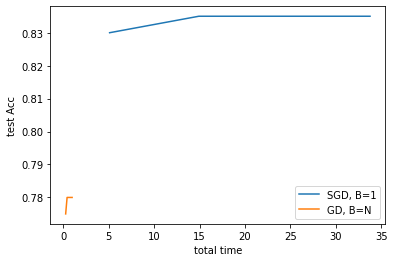

In [ ]:
sns.lineplot(x="total time", y="test Acc", data=results_pd, label="SGD, B=1")
sns.lineplot(x="total time", y="test Acc", data=results_true_gd, label="GD, B=N")

When we use SGD, we perform $N$ updates per epoch, so we get more updates or steps
for a fixed number of epochs. But because of the stochastic or random behavior of using
just one data point for each update, the steps we take are noisy.

The solution we use in practice is to balance between these two extremes.

Let’s choose a batch size big enough to use the CPU/GPU more efficiently but small enough that we still get to perform many more updates per epoch.

In [ ]:
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
model_sgd = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)

results_batched = train_network(model_sgd, 
                                loss_func, 
                                training_loader,
                                epochs=5, test_loader=testing_loader,
                                checkpoint_file="model.pt",
                                score_funcs={"Acc": accuracy_score, "F1": f1_score})

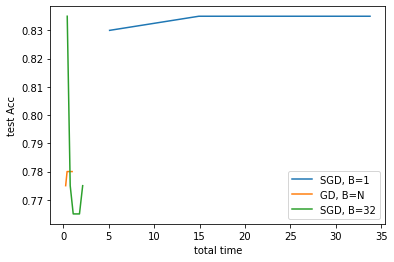

In [ ]:
sns.lineplot(x="total time", y="test Acc", data=results_pd, label="SGD, B=1")
sns.lineplot(x="total time", y="test Acc", data=results_true_gd, label="GD, B=N")
sns.lineplot(x="total time", y="test Acc", data=results_batched, label="SGD, B=32")